# Generative Adversarial Networks
GANs are a unique type of neural network that pits two models against each other in order to ultimately create a model that can generate novel output when provided random noise.


In [1]:
#Imports
import torch, torchvision
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.nn import Module, Sequential, Linear, ReLU, BatchNorm1d, Sigmoid
import matplotlib.pyplot as plt

In [2]:
SEED = 1
torch.manual_seed(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu" 
IMAGE_WIDTH = 28
NOISE_SIZE = 49
print(f"Using random seed: {SEED}")
print(f"Using Device: {DEVICE}")

Using random seed: 1
Using Device: mps


## Data
The raw MNIST data is stored in a [B, H, W] int8 tensor, so we need to convert and rescale the data

In [3]:
# Dataloading
class MNISTDataset(Dataset):
    def __init__(self):
        mnist_data = torchvision.datasets.MNIST('data/mnist', 
                                        download=True)
        self.data = mnist_data.data.to(dtype=torch.float32, device=DEVICE) / 255
        self.data = self.data.flatten(1)
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        return self.data[idx]

### Dataloading Preview

In [4]:
def display_tensor(tensor):
    images = tensor.reshape(-1, IMAGE_WIDTH, IMAGE_WIDTH)
    _, ax = plt.subplots(ncols=len(images))
    for i, image in enumerate(images):
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].imshow(image, cmap='gray')
    plt.show()

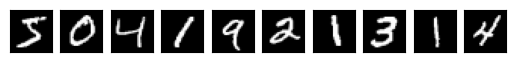

In [5]:
mnist_data = MNISTDataset()
display_tensor(mnist_data[0:10].cpu())

In [6]:
class ResidualLayer(Module):
    def __init__(self, sequential):
        super().__init__()
        self.sequential = sequential

    def forward(self, x):
        return x + self.sequential(x)

In [7]:
# Discriminator
def create_discriminator():
    return Sequential(
            ResidualLayer(Sequential(
                BatchNorm1d(784),               # TODO: MAYBE CHANGE
                Linear(784, 784),       
                ReLU()
            )),
            BatchNorm1d(784),
            Linear(784, 392),
            ReLU(),
            ResidualLayer(Sequential(
                BatchNorm1d(392),
                Linear(392, 392),
                ReLU()
            )),
            BatchNorm1d(392),
            Linear(392, 1),
            Sigmoid()
        ).to(device=DEVICE)

In [8]:
def discriminator_loss_fn(predictions, labels, epsilon = 1e-5):
    return -torch.mean(torch.log(epsilon + 1 - torch.abs(predictions - labels))) + epsilon

# Train Discriminator    
def discriminator_train_step(discriminator, real_images, fake_images, optimizer):
    optimizer.zero_grad()

    images = torch.cat([real_images, fake_images])

    # Create labels for the samples
    labels = torch.cat((torch.ones(len(real_images), device=DEVICE), 
                        torch.zeros(len(fake_images), device=DEVICE)))
    
    # Compute predictions and update the parameters
    predictions = discriminator(images).squeeze(dim = 1)
    loss = discriminator_loss_fn(predictions, labels)
    loss.backward()
    optimizer.step()

    return loss

We'll feed the disciminator noise images to see if it can distinguish them from actual MNIST datas

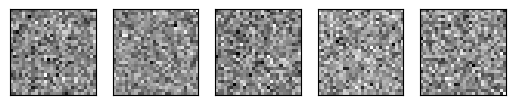

In [9]:
fake_images = torch.randn(5, IMAGE_WIDTH, IMAGE_WIDTH)
display_tensor(fake_images)

In [10]:
discriminator = create_discriminator()
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr = 0.0002, betas=(0.5, 0.9))
for real_images in DataLoader(mnist_data, batch_size=256):
    # Generate random noise to train against
    fake_images = torch.randn_like(real_images)

    loss = discriminator_train_step(discriminator, real_images, fake_images, discriminator_optimizer)
    print("Loss: {:10.7f}".format(loss), end='\r')

In [11]:
# Generator
def create_generator():
    return Sequential(
            ResidualLayer(Sequential(
                BatchNorm1d(49),
                Linear(49, 49),
                ReLU()
            )),
            BatchNorm1d(49),
            Linear(49, 98),
            ReLU(),
            ResidualLayer(Sequential(
                BatchNorm1d(98),
                Linear(98, 98),
                ReLU()
            )),
            BatchNorm1d(98),
            Linear(98, 196),
            ReLU(),
            ResidualLayer(Sequential(
                BatchNorm1d(196),
                Linear(196, 196),
                ReLU()
            )),
            BatchNorm1d(196),
            Linear(196, 392),
            ReLU(),
            ResidualLayer(Sequential(
                BatchNorm1d(392),
                Linear(392, 392),
                ReLU()
            )),
            BatchNorm1d(392),
            Linear(392, 784),
            ResidualLayer(Sequential(
                BatchNorm1d(784),
                Linear(784, 784),
                ReLU()
            )),
            Sigmoid()
        ).to(device=DEVICE)

In [12]:
def generator_loss_fn(predictions, epsilon = 1e-5):
    return -torch.mean(torch.log(epsilon + predictions))

# Train Generator
def generator_train_step(generator, discriminator, batch_size, generator_optimizer, discriminator_optimizer):
    generator_optimizer.zero_grad()
    discriminator_optimizer.zero_grad()

    noise = torch.randn(batch_size, NOISE_SIZE, device=DEVICE)
    generated_images = generator(noise)
    
    # Compute predictions and update the parameters
    predictions = discriminator(generated_images).squeeze(dim = 1)
    loss = generator_loss_fn(predictions)
    loss.backward()
    generator_optimizer.step()

    return loss

Now let's train our Model! But first we need to define some evaluation functions, so we can see what's going on.

In [13]:
# Evaluation
def evaluate(generator, discriminator, dataloader):
    # Variables for tracking stats as we iterate through the data in batches
    total_samples = 0
    correct_on_real_images = 0
    correct_on_generated_images = 0

    for batch in dataloader:
        # Get number correct on real images
        real_preds = discriminator(batch).squeeze(dim=1)
        correct_on_real_images += (real_preds > 0.5).sum()

        # Get number correct on generated images
        noise = torch.randn(len(batch), NOISE_SIZE, device=DEVICE)
        generated_preds = discriminator(generator(noise)).squeeze(dim=1)
        correct_on_generated_images += (generated_preds < 0.5).sum()
        
        # Track how many images we've seen
        total_samples += len(batch)
    
    # Calculate Accuracies
    real_correct_acc = correct_on_real_images / total_samples
    generated_correct_acc = correct_on_generated_images / total_samples

    return real_correct_acc, generated_correct_acc

In [14]:
discriminator = create_discriminator()
generator = create_generator()

discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr = 0.0002, betas=(0.5, 0.9))
generator_optimizer = torch.optim.Adam(generator.parameters(), lr = 0.0001, betas=(0.5, 0.9))

batch_size=64

for epoch in range(10):
    print("-------------------------------------------------")
    print(f"Epoch {1 + epoch}")
    # Training Loop
    for real_images in tqdm(DataLoader(mnist_data, batch_size=batch_size)):
        # Discriminator training loop
        discriminator.train()
        generator.eval()

        noise = torch.randn(batch_size, NOISE_SIZE, device=DEVICE)
        fake_images = generator(noise)
        discriminator_train_step(discriminator, real_images, fake_images, discriminator_optimizer)

        # Generator training subroutine
        discriminator.eval()
        generator.train()
        generator_train_step(generator, discriminator, batch_size, generator_optimizer, discriminator_optimizer)
    
    # Evaluate current performance
    real_correct_acc, generated_correct_acc = evaluate(generator, discriminator, DataLoader(mnist_data, batch_size=60000))
    print()
    print(f"Real Image Accuracy:      {real_correct_acc}")
    print(f"Generated Image Accuracy: {generated_correct_acc}")

-----------------------------------------------
Epoch 1


100%|██████████| 938/938 [00:31<00:00, 29.37it/s]


Real Image Accuracy:      0.9997333288192749
Generated Image Accuracy: 1.0
-----------------------------------------------
Epoch 2


 92%|█████████▏| 865/938 [00:30<00:02, 28.25it/s]


KeyboardInterrupt: 